# Genetic algorithms using `numpy`

In this demonstration, we will code up step-by-step, a simple GA for optimizing a trivial function with constraints. Further exploration in this example would be very useful for your project.

In [1]:
import numpy as np
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Problem statement

We need to maximize the function  $ f(\mathbf{x}) = \sum_{i=1}^{6} w_i x_i $ for a given set of weights $ w_i $, with the constraints that $ x_i \; \in \; [-4,4] \; \forall \; i$. This means that the domain $\mathbb{D}$ of the search is $ \mathbb{D}:= [-4,4]^6$. The optimization problem can be succinctly represented as $\left(\mathbb{D}, \mathbb{R} , \mathbf{f}, \geq \right)$.

## Ease of solving the problem

We note that this example is trivial because given a set of weights, we need to pick either $x_i=-4$ or $x_i=4$ as the objective function is linear. That's precisely the point however, as we know the solution to the problem, and we can compare how GA performs (as a search algorithm in itself, and against design parameters)

## Given
The weight vector $\mathbf{w} = [6,8,-6,3,3,-4]$. For this case then, the optimal solution is $\mathbf{x}^* = [4, 4, -4, 4, 4, -4]$ which gives a maximum possible objective value $f^* = 120$

In [2]:
N_WEIGHTS = 6 # Helper variable
WEIGHTS = np.array([6,8,-6,3,3,-4], dtype = np.float64) # Optional dtype argument

In [3]:
# Confirm the shape so that we are happy
np.shape(WEIGHTS)

(6,)

#  Representation

How do you want to encode this problem? To keep the demonstration simple, we pick a set of 6 floating point numbers (as a `numpy` array) directly. We need to keep in mind that variation needs to be done on this representation.

In [4]:
# I can define my optimal solution vector now, since I have decided my representation
X_STAR = np.array([4, 4, -4, 4, 4, -4], dtype = np.float64)

Now that we have picked representation, let's start off the problem. We need to pick a population size (i.e. number of parents in the initial generation). Let's pick a nice number, say 10  

In [5]:
# Size of the population
POP_SIZE = 10

Remember! Each member of this population is a vector with shape `(6,)`. Is there a way to efficiently represent/generate/work with this entire population all at one go?

Of course! Put them together as a 2 dimensional array!

In [6]:
# Helper variable that generates POP_SIZE x NUM_WEIGHTS population
DOFS_IN_POP = (POP_SIZE, N_WEIGHTS)

The population will have `POP_SIZE` chromosomes where each chromosome has `NUM_WEIGHTS` genes. Let's generate the initial population that our GA algorithm will work on. This population needs to be randomly initialized, say around $0.0$. The `numpy.random` module comes to mind

In [7]:
curr_population = np.random.uniform(low=-4.0, high=4.0, size=DOFS_IN_POP)
# What about these guys?
# curr_population = np.random.rand?
# curr_population = np.random.rand_sample?

In [8]:
curr_population

array([[-2.69783986, -1.78361616, -1.07061314,  3.17705276,  1.20823729,
         3.46335124],
       [ 2.44023339, -0.31676032,  2.46736275, -3.02497408,  0.87641835,
         1.85444102],
       [ 0.20403843, -2.03992215, -1.82103833, -1.4004631 , -0.68256158,
         0.62429486],
       [-3.28449017, -0.55733785, -0.51827937,  3.09076266, -3.10498344,
        -3.18905522],
       [-3.69160858, -1.79917789,  0.11714879, -3.05037617,  2.62084839,
         1.37684144],
       [-2.43985062, -2.37558996, -3.56567927,  1.72261945,  0.37267021,
         3.59681509],
       [ 1.34636274,  2.34169474, -2.65535623, -0.54296561,  2.15652304,
         0.14226009],
       [-3.46597406,  2.83370779,  1.13521033, -3.81429689,  1.28856787,
        -0.04113665],
       [-2.00277283,  2.40770721,  2.14166245,  3.3953563 , -3.15028717,
         2.11341283],
       [-3.15977928, -1.24327789,  2.23493868,  0.2703171 , -3.34738107,
        -1.30558823]])

# Fitness assignment
In this demo, we assign fitness directly using the objective function (without penalty, we'll deal with constraints later on). However you can best decide what fitness works for your problem (competitive? informal?...)

In [9]:
def calc_fitness(t_pop):
    """ Calculates fitness given the population using global weights
    The fitness function calulates the sum of products between each input and its corresponding weight.
    Returns a (POP_SIZE, ) numpy array
    """        
    # Do elementwise across columns, then sum the columns up together
    # fitness = np.sum(t_pop * WEIGHTS, axis=1)

    # Do a matrix vector multiply of (10,6) * (6,)
    fitness = t_pop @ WEIGHTS

    # There are other ways to do the same thing, but why would you?
    return fitness

In [10]:
my_fitness = calc_fitness(curr_population)
print(my_fitness)
print(my_fitness.shape)

[-24.72982443 -16.56028994 -12.91517018  -8.34240906 -44.04191648
 -20.35113919  47.01550367 -12.35008447 -13.32339791 -46.32336981]
(10,)


# Selection for variation

### How do you select parents to spread their genes? 
One way to do it is to select *best* parents only to mate. This is an example of a **determinstic selection scheme**, wherein we rank them by fitness and consider the best ones.

### How many parents to select for mating? 
This is up to the user. Some people prefer to use heuristics based on the population size for determining the mating pool size. Sometimes it depends on the selection scheme used (for example, in tournament selection where the $T$ parameter, along with the population size determines the mating pool size).

For simplicity in this demo, let's fix the number of parents that are selected to mate at every iteration and store it as a variable.


In [11]:
N_MATING = 4

def select_determinstic(t_pop, t_fitness):
    """ Given current population t_pop, select N_MATING number of parents using determinstic selection scheme
    based on t_fitness 

    Returns parents and their fitness (just because)
    """
    # Returns sorting indices, based on max fitness
    # Arranged from min-> max fitness
    idx = np.argsort(t_fitness)
    # Now its max fitness on top and min on bottom
    idx = idx[::-1]

    # Select parents according to the index
    parents = t_pop[idx]

    # Select best parents
    parents = parents[:N_MATING, :]
    return (parents, calc_fitness(parents))

    
    ''' If you don't want to reverse, you can do the following
    '''
#     # Returns sorting indices, based on max fitness
#     # Arranged from min-> max fitness
#     idx = np.argsort(t_fitness)

#     # Select parents according to the index
#     parents = t_pop[idx]

#     # Select best parents
#     parents = parents[-N_MATING:, :]
#     return (parents, calc_fitness(parents))

    
    '''You can also do it in a convoluted way like below, but I don't recommend it
    Always code like some other person is watching you code''' 

#     # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
#     parents = numpy.empty((num_parents, pop.shape[1]))
#     for parent_num in range(num_parents):
#         max_fitness_idx = numpy.where(fitness == numpy.max(fitness))
#         max_fitness_idx = max_fitness_idx[0][0]
#         parents[parent_num, :] = pop[max_fitness_idx, :]
#         fitness[max_fitness_idx] = -99999999999
#     return parents

In [12]:
my_parents, my_parents_fit = select_determinstic(curr_population, my_fitness)
my_parents
my_parents_fit

array([[ 1.34636274,  2.34169474, -2.65535623, -0.54296561,  2.15652304,
         0.14226009],
       [-3.28449017, -0.55733785, -0.51827937,  3.09076266, -3.10498344,
        -3.18905522],
       [-3.46597406,  2.83370779,  1.13521033, -3.81429689,  1.28856787,
        -0.04113665],
       [ 0.20403843, -2.03992215, -1.82103833, -1.4004631 , -0.68256158,
         0.62429486]])

array([ 47.01550367,  -8.34240906, -12.35008447, -12.91517018])

### Can you show me an example of stochastic selection?

Let's implement Stochastic Universal Sampling, which consists of

* Sampling rate assignment
* Sampling

In [13]:
def select_stochastic(t_pop, t_fitness):
    """ Given current population t_pop, select N_MATING number of parents using SUS
    based on t_fitness 

    Returns parents and their fitness (just because)
    """

    ''' Sampling rate assignment using linear rank-based sampling
    '''
    # Rank based on max fitness
    # Arranged from min-> max fitness
    # Do the same for parents later on
    idx = np.argsort(t_fitness)

    # Copied shamelessly from https://stackoverflow.com/a/5284703
    r_i = np.empty_like(idx)
    r_i[idx] = np.arange(len(t_fitness))
 
    # Same as 
    # r_i = np.argsort(idx)

    """
        >>> t_fitness
        >>> array([-18.29817097,  22.688013  ,  65.55614464, -22.39372802,
           -11.53236791,  40.55497738, -13.77672983,  14.9189356 ,
            60.09509336,  32.67900684])

        >>> idx
        >>> [3 0 6 4 7 1 9 5 8 2]

        >>> r_i
        >>> [1 5 9 0 3 7 2 4 8 6]
    """

    # Calculate linear weighting with alpha = 2
    p_i = r_i + 2

    # Calculate q_i as an avverage measure of p_i
    sum_pi = np.sum(p_i)
    q_i = p_i / sum_pi

    # Rank from biggest to least for ease of use
    q_idx = np.argsort(q_i)

    # Regular q_i is for t_pop
    # The sorted q_i is now for (t_pop)[q_idx]
    # The reversed q_i is then for ((t_pop)[q_idx])[::-1]
    
    q_i = q_i[q_idx]
    q_i = q_i[::-1]


    ''' With this sampling rate q_i pick up four parents
    '''
    # Increment to generated random number
    random_increment = 1./N_MATING

    # Generate a random number
    random_val = np.random.rand(1, )

    # Select four zones of q_i to select
    arrow_locations = random_val + random_increment * np.arange(N_MATING)
    """    
        >>> arrow_locations
        >>> [0.52196859 0.77196859 1.02196859 1.27196859]
    """
    
    # Ensure it stays within 1
    arrow_locations %= 1
    """    
        >>> arrow_locations
        >>> [0.52196859 0.77196859 0.02196859 0.27196859]
    """

    # In place sorting to get (r, r+1/N_MATING, r + 2/N_MATING ...., r + (N_MATING-1)/N_MATING)
    arrow_locations.sort()
    """    
        >>> arrow_locations
        >>> [0.02196859 0.27196859 0.52196859 0.77196859]
    """

    # Based on arrow locations, pick the parents
    cum_qi = np.cumsum(q_i)
    """    
        >>> cum_qi
        >>> [0.16923077 0.32307692 0.46153846 0.58461538 0.69230769 0.78461538
     0.86153846 0.92307692 0.96923077 1.        ]
    """
    
    # Where do you find the arrows within cum_qi
    zone_belong = np.searchsorted(cum_qi, arrow_locations)
    # print(zone_belong)
    """    
        >>> zone_belong
        >>> [0 1 3 5]
    """

    # zone_belong returns index of individuals in the max-->min list 
    # I want indices in the min--> max list
    # One hacky way of doing this is just do a size-1 subtraction
    zone_belong = POP_SIZE - zone_belong - 1
    
    # The q_i of the selected indviduals
    parents = t_pop[q_idx][zone_belong]
    par_fitness = t_fitness[q_idx][zone_belong]

    return (parents, par_fitness)

In [14]:
my_parents, my_par_fitness = select_stochastic(curr_population, my_fitness)
my_parents
my_par_fitness

array([[ 1.34636274,  2.34169474, -2.65535623, -0.54296561,  2.15652304,
         0.14226009],
       [-3.28449017, -0.55733785, -0.51827937,  3.09076266, -3.10498344,
        -3.18905522],
       [ 0.20403843, -2.03992215, -1.82103833, -1.4004631 , -0.68256158,
         0.62429486],
       [ 2.44023339, -0.31676032,  2.46736275, -3.02497408,  0.87641835,
         1.85444102]])

array([ 47.01550367,  -8.34240906, -12.91517018, -16.56028994])

# Variation
Variation has two operations : crossover/recombination (produce new offspring from the parents selected in the prior step) and mutation (produced mutated/randomly offset offspring). Let's see each one separately.

### Recombination
For this demonstration, lets do a one-point crossover. This means we naively *mix* the solution vectors---we take some  components (among the six) from one parent and the rest from another parent... 

Before proceeding, we want to determine the limit of offspring vectors to be produced. This has to be a reasonable number and should depend on the population and the number of parents selected for mating. This also corresponds to the $\lambda$ deterministic selection schemes.

We also need to select $p_c$, the crossover rate---it determines the probability of a crossover happening between two parents.

In [15]:
N_OFFSPRING = 3
IDX_CROSSOVER = 3

In our demo, let's fix $p_c$ to 1 (recombination happens always). We also fixed the offspring size above to $0.5 \cdot {\text{N_MATING}\choose 2} = 3$. This allows every selected parent to propogate their genes. The parent vectors are chosen in a fixed fashion (1 mates with 2, 2 with 3 and so on...)

Where to crossover? Sometimes we use an additional random integer (respecting array range constraints) that determines at which location a crossover should occur. In our example below, let's perform a *uniform* one-point crossover (uniform in the sense that we always do crossover at a selected index)

In [16]:
def crossover(t_parents):
    """ Given a set of parents, combine them and return offspring vectors
    
    Returns the offsprings and their fitness
    """
    
    # Create an emppty vector
    offspring = np.empty((N_OFFSPRING, N_WEIGHTS))

    for k in range(N_OFFSPRING):
        # We do % N_MATING in case it goes out of range
        
        # Index of the first parent to mate.
        p1_idx = k%N_MATING

        # Index of the second parent to mate.
        p2_idx = (k+1)%N_MATING
        
        # The new offspring will have its first half of its genes taken from the first parent.
        offspring[k, :IDX_CROSSOVER] = t_parents[p1_idx, :IDX_CROSSOVER]

        # The new offspring will have its second half of its genes taken from the second parent.
        offspring[k, IDX_CROSSOVER:] = t_parents[p2_idx, IDX_CROSSOVER:]

    return (offspring, calc_fitness(offspring))

Does crossover create new offspring?

In [17]:
my_offspring,  my_offspring_fitness = crossover(my_parents)
my_parents
my_offspring

array([[ 1.34636274,  2.34169474, -2.65535623, -0.54296561,  2.15652304,
         0.14226009],
       [-3.28449017, -0.55733785, -0.51827937,  3.09076266, -3.10498344,
        -3.18905522],
       [ 0.20403843, -2.03992215, -1.82103833, -1.4004631 , -0.68256158,
         0.62429486],
       [ 2.44023339, -0.31676032,  2.46736275, -3.02497408,  0.87641835,
         1.85444102]])

array([[ 1.34636274,  2.34169474, -2.65535623,  3.09076266, -3.10498344,
        -3.18905522],
       [-3.28449017, -0.55733785, -0.51827937, -1.4004631 , -0.68256158,
         0.62429486],
       [ 0.20403843, -2.03992215, -1.82103833, -3.02497408,  0.87641835,
         1.85444102]])

It does! Are the offsprings fitter than their parents?

In [18]:
my_par_fitness
my_offspring_fitness

array([ 47.01550367,  -8.34240906, -12.91517018, -16.56028994])

array([ 55.45743026, -29.80222108, -18.03234794])

They are! This is good news...

### Mutation
For this demonstration, lets add uniform random numbers drawn between $[-0.5, 0.5)$ to the offspring. But let's not do it everytime---we will do that with a probability $p_m = 0.5$, sampled for each offspring. Recollect that this is the muation rate parameter.

In [19]:
PM = 0.5
def mutation(t_offspring):
    """ Given a set of offsprings, introduce mutation in them
   
    Returns the mutated offsprings and their fitness
    """

    # Mutation changes all genes in each offspring randomly.
    # You can also code for a single gene, single gene with some probability and so on...

    # Generate a random number in [0, 1) to mutate each offspring
    random_mutator = np.random.uniform(0.0, 1.0, (N_OFFSPRING,))

    # Check where the random_mutator is > PM
    # Gives true in those places
    idx = random_mutator > PM

    # Count number of trues in the above condition
    nnz = np.count_nonzero(idx)

    # Copy just for comparison of offspring before and after mutation
    # You can remove if efficiency is a concern
    mutated_offspring = t_offspring.copy()

    # For true idx, add randomly sampled vector in [-0.5, 0.5)
    # print(random_mutator, idx)
    mutated_offspring[idx] += np.random.uniform(-0.5, 0.5, (nnz, N_WEIGHTS))
    
    return (mutated_offspring, calc_fitness(mutated_offspring))

Can we see some mutation?

In [20]:
my_mut_offspring, my_mut_offspring_fitness = mutation(my_offspring)
my_offspring
my_mut_offspring

array([[ 1.34636274,  2.34169474, -2.65535623,  3.09076266, -3.10498344,
        -3.18905522],
       [-3.28449017, -0.55733785, -0.51827937, -1.4004631 , -0.68256158,
         0.62429486],
       [ 0.20403843, -2.03992215, -1.82103833, -3.02497408,  0.87641835,
         1.85444102]])

array([[ 1.42031284,  2.80395761, -2.22407581,  3.36941255, -2.66198979,
        -3.64796691],
       [-3.28449017, -0.55733785, -0.51827937, -1.4004631 , -0.68256158,
         0.62429486],
       [ 0.20403843, -2.03992215, -1.82103833, -3.02497408,  0.87641835,
         1.85444102]])

# Environmental selection
The final step is environmental selection. This comes in two parts:

1) Imposing any hard constraints, such as those violating range being chucked out

2) Picking the `POP_SIZE` best individuals and sending them to the next generation



Let's first throw out any individuals not adhering to the limits set by or constraints

In [21]:
def hard_constraint(t_total_pop):
    """ Scans the array for individual violating constraint bounds
    and chucks them out of processing

    t_all includes all vectors (parents + mutated offsprings)
    """
    idx1 = (t_total_pop >= -4.0)
    idx2 = (t_total_pop <= 4.0)

    # And condition as both must be satisfied
    idx = idx1 & idx2

    # Returns an entire row as false even if one evaluares to False
    # The axis argument tells along which axis it should scan
    idx = np.all(idx, axis=1)

    return t_total_pop[idx]

Let's see if the constraint check passes. Let's concatenate all vectors into one big unit and do constraint check.

In [22]:
# Testing constraints 
# Group curr_population, my_parents, my_mut_offspring here
# Stack them one top of another
total_population = np.vstack((curr_population, my_mut_offspring))

# Verify shape
total_population.shape

total_population = hard_constraint(total_population)

(13, 6)

We then pick the top `POP_SIZE` individuals next, based on their fitness

In [23]:
def environmental_selection(t_total_pop):
    """ Calculate total population (after constraint checking) fitness,
    rank accoridingly and select only the top POP_SIZE individuals to
    pass on to the next generation
    """ 

    tot_fitness = calc_fitness(t_total_pop)
    
    # Calculate elements from small->top fitness
    idx = np.argsort(tot_fitness)
    
    # Reverse to give top->small fitness
    idx = idx[::-1]
    
    # Cut off POP_SIZE elements
    idx = idx[:POP_SIZE]

    # Return corresponding population
    return t_total_pop[idx]

Check whether selecting top 10 works...

In [24]:
print("Before")
total_population.shape
calc_fitness(total_population)
new_population = environmental_selection(total_population)
print("After")
new_population.shape
calc_fitness(new_population)

Before


(13, 6)

array([-24.72982443, -16.56028994, -12.91517018,  -8.34240906,
       -44.04191648, -20.35113919,  47.01550367, -12.35008447,
       -13.32339791, -46.32336981,  61.01212876, -29.80222108,
       -18.03234794])

After


(10, 6)

array([ 61.01212876,  47.01550367,  -8.34240906, -12.35008447,
       -12.91517018, -13.32339791, -16.56028994, -18.03234794,
       -20.35113919, -24.72982443])

# Let's hook them all up together!

And add some utilities to help us track progress

In [25]:
best_outputs = []
num_generations = 1000
curr_population = np.random.uniform(low=-4.0, high=4.0, size=DOFS_IN_POP)
overall_max_fitness = -99999

# Run many iterations
# You should also have another convergence check
for generation in range(num_generations):
    print("Generation : ", generation)

    # Measuring the fitness of each chromosome in the population.
    fitness = calc_fitness(curr_population)

    # print("Fitness")
    # print(fitness)

    max_fitness = np.max(fitness)

    # The best result in the current iteration.
    print("Best result in current iteration {0} compared to overall {1}".format(max_fitness, max(max_fitness, overall_max_fitness)))
    best_outputs.append(max_fitness)
    
    # Selecting the best parents in the population for mating.
    parents, _ = select_determinstic(curr_population, fitness)

    # print("Parents")
    # print(parents)

    # Generating next generation using crossover.
    offspring_crossed, _ = crossover(parents)

    # print("Crossover")
    # print(offspring_crossover)

    # Adding some variations to the offspring using mutation.
    offspring_mutated, _ = mutation(offspring_crossed)

    # print("Mutation")
    # print(offspring_mutation)

    # Check for constraints
    total_population = np.vstack((curr_population, offspring_mutated))
    total_population = hard_constraint(total_population)

    # Environmental selection
    curr_population = environmental_selection(total_population)
              
# Getting the best solution after iterating finishing all generations.
#At first, the fitness is calculated for each solution in the final generation.
fitness = calc_fitness(curr_population)

# Then return the index of that solution corresponding to the best fitness.
max_idx = np.argmax(fitness)

print("Best solution : ", new_population[max_idx, :])
print("Best solution fitness : ", fitness[max_idx])

Generation :  0
Best result in current iteration 24.00984790403578 compared to overall 24.00984790403578
Generation :  1
Best result in current iteration 25.830717251500047 compared to overall 25.830717251500047
Generation :  2
Best result in current iteration 46.816962045029406 compared to overall 46.816962045029406
Generation :  3
Best result in current iteration 46.816962045029406 compared to overall 46.816962045029406
Generation :  4
Best result in current iteration 46.816962045029406 compared to overall 46.816962045029406
Generation :  5
Best result in current iteration 46.816962045029406 compared to overall 46.816962045029406
Generation :  6
Best result in current iteration 47.312157837695466 compared to overall 47.312157837695466
Generation :  7
Best result in current iteration 47.32797971198767 compared to overall 47.32797971198767
Generation :  8
Best result in current iteration 47.32797971198767 compared to overall 47.32797971198767
Generation :  9
Best result in current iter

Generation :  118
Best result in current iteration 110.5320684000668 compared to overall 110.5320684000668
Generation :  119
Best result in current iteration 110.9766114461275 compared to overall 110.9766114461275
Generation :  120
Best result in current iteration 110.9766114461275 compared to overall 110.9766114461275
Generation :  121
Best result in current iteration 110.9766114461275 compared to overall 110.9766114461275
Generation :  122
Best result in current iteration 110.9766114461275 compared to overall 110.9766114461275
Generation :  123
Best result in current iteration 110.9766114461275 compared to overall 110.9766114461275
Generation :  124
Best result in current iteration 110.9766114461275 compared to overall 110.9766114461275
Generation :  125
Best result in current iteration 110.9766114461275 compared to overall 110.9766114461275
Generation :  126
Best result in current iteration 110.9766114461275 compared to overall 110.9766114461275
Generation :  127
Best result in curr

Generation :  363
Best result in current iteration 113.0250155109111 compared to overall 113.0250155109111
Generation :  364
Best result in current iteration 113.0250155109111 compared to overall 113.0250155109111
Generation :  365
Best result in current iteration 113.0250155109111 compared to overall 113.0250155109111
Generation :  366
Best result in current iteration 113.0250155109111 compared to overall 113.0250155109111
Generation :  367
Best result in current iteration 113.0250155109111 compared to overall 113.0250155109111
Generation :  368
Best result in current iteration 113.0250155109111 compared to overall 113.0250155109111
Generation :  369
Best result in current iteration 113.0250155109111 compared to overall 113.0250155109111
Generation :  370
Best result in current iteration 113.0250155109111 compared to overall 113.0250155109111
Generation :  371
Best result in current iteration 113.0250155109111 compared to overall 113.0250155109111
Generation :  372
Best result in curr

Generation :  720
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  721
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  722
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  723
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  724
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  725
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  726
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  727
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  728
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  729
B

Generation :  805
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  806
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  807
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  808
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  809
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  810
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  811
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  812
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  813
Best result in current iteration 115.51821270453385 compared to overall 115.51821270453385
Generation :  814
B

<Figure size 864x864 with 0 Axes>

Text(0.5,0,'Iteration')

Text(0,0.5,'Fitness')

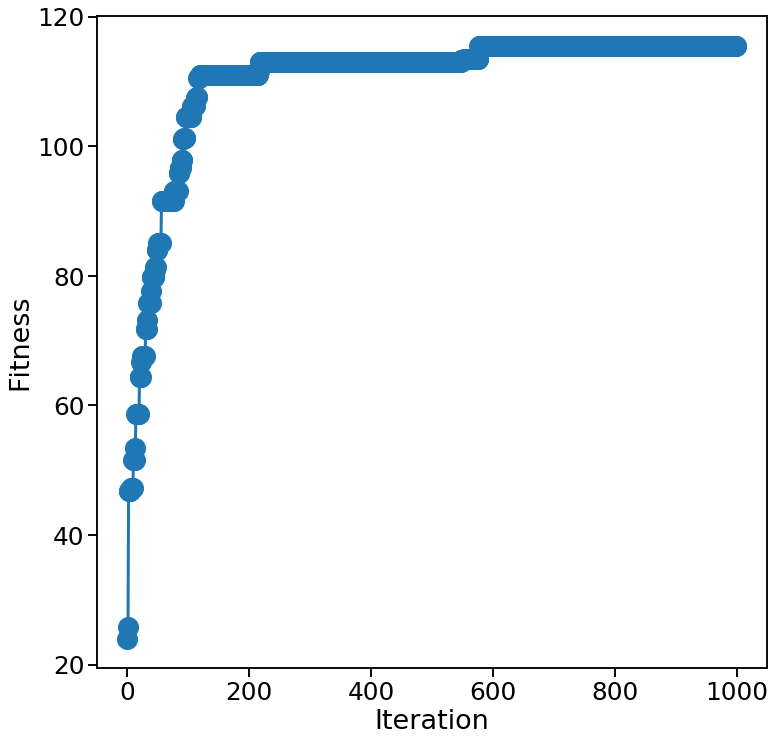

In [27]:
import pylab as plt
import seaborn as sns
sns.set_context("talk", font_scale=1.5, rc={"lines.linewidth": 2.5})

%matplotlib inline
plt.figure(figsize=(12,12))
plt.plot(best_outputs,'-o', lw=3, ms=20, label='from scratch')
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.show()